<a href="https://colab.research.google.com/github/biaferre/projeto-aprendizado-supervisionado/blob/main/Projeto_Supervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial settings

## Library imports

In [1]:
!pip install kaggle
!pip install opendatasets --upgrade --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as sty
import seaborn as sns
import os
import opendatasets as od
import json
import graphviz
import tensorflow as tf

In [2]:
# extra sklearn and visualizing tools
!pip install scikit-learn-extra

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn import tree as tree
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report , accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.0 MB/s eta 0:00:00


## Dataset imports

In [168]:
dataset = 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package'
od.download(dataset)
!ls

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)
sample_data  weather-dataset-rattle-package


In [169]:
df = pd.read_csv("./weather-dataset-rattle-package/weatherAUS.csv")
ori = pd.read_csv("./weather-dataset-rattle-package/weatherAUS.csv")

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Engineering and Scaling

### Initial settings

Firstly, we must replace the boolean categorical values (RainToday and RainTomorrow) that are yes/no values with 1/0 respectively:

In [170]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

Visualizing correlation:

<ipython-input-171-85a6e416a589>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


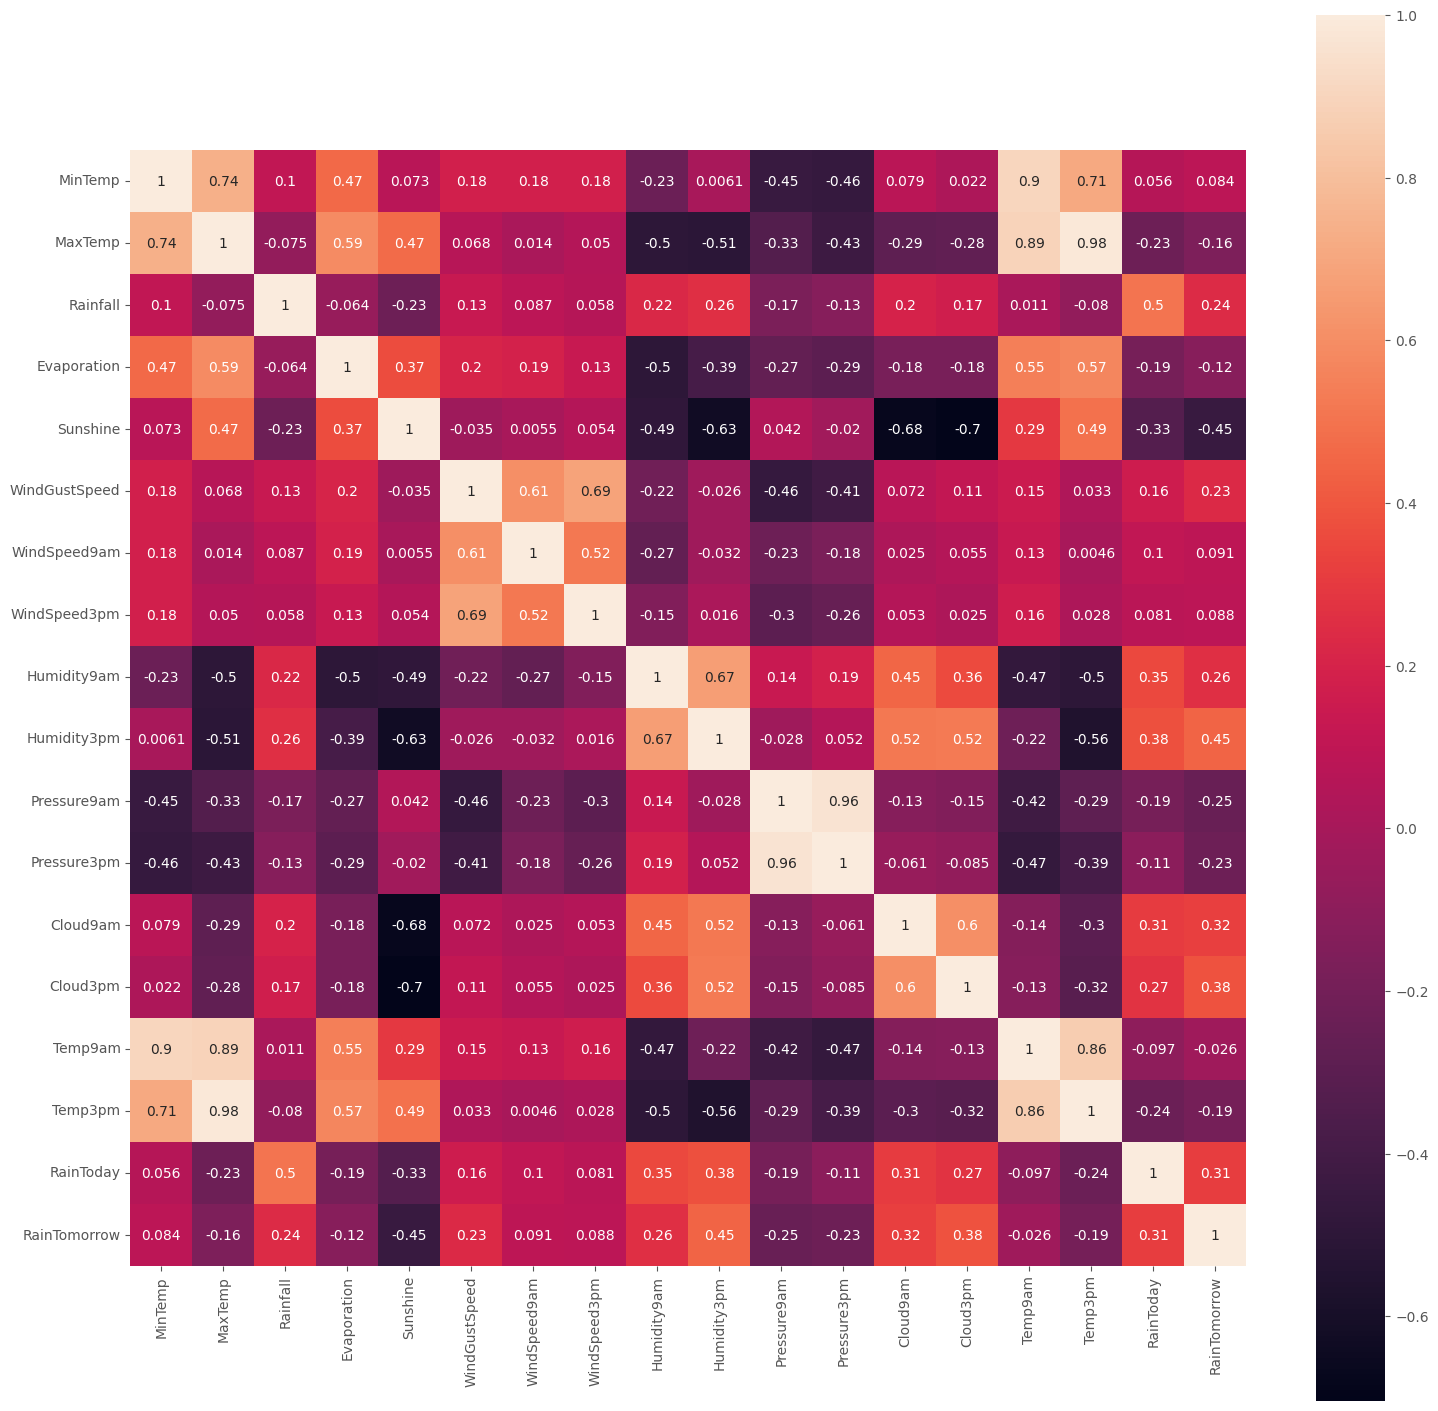

In [171]:
correlation = df.corr()
plt.figure(figsize=(18,18))
sns.heatmap(correlation, annot=True, square=True)
plt.show()

### Removing Mostly Empty Columns

There are some columns with high percentage of null values:

In [172]:
df.isnull().mean().sort_values(ascending=False)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

Let's drop the columns that have high null value percentage, which are Evaporation, Sunshine, Cloud9am and Cloud3pm.
We'll drop Date as well since it has no bearing on our predictions.

In [173]:
df = df.drop(['Date','Evaporation','Sunshine','Cloud9am','Cloud3pm'], axis=1)
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0.0
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.0,0.0
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.0,0.0
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.0,0.0
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.0,0.0


Visualizing the columns we now have:

In [174]:
df.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

### Selecting Subset from Data

Because our dataset is too big, we're restricting the prediction to Sydney for computational efficiency purposes. However, this collab works just fine if you skip this and just work with the full dataset (it'll just take a much longer time).

In [175]:
df = df.sample(n=30000,random_state=42).copy()
df

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
100721,MountGambier,15.0,18.9,4.2,NNW,54.0,NNW,NW,24.0,31.0,73.0,64.0,1005.2,1003.7,17.3,17.6,1.0,1.0
30234,Sydney,13.1,26.8,0.0,NaN,NaN,W,WNW,22.0,15.0,61.0,22.0,1013.0,1009.0,16.9,25.9,0.0,0.0
68427,Melbourne,19.0,29.0,NaN,N,59.0,N,N,39.0,22.0,50.0,38.0,1006.5,1003.4,24.2,27.2,NaN,NaN
28624,Richmond,18.1,32.2,0.0,NE,30.0,NaN,NE,0.0,17.0,99.0,51.0,1019.2,1014.6,20.9,31.6,0.0,0.0
31173,Sydney,13.9,19.6,14.0,SSW,50.0,SW,S,17.0,22.0,90.0,64.0,NaN,1018.4,15.5,19.1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86179,Brisbane,12.4,23.6,0.0,NE,24.0,WSW,ENE,4.0,13.0,66.0,59.0,1022.6,1018.3,19.3,22.4,0.0,0.0
59428,Bendigo,3.4,13.1,1.0,ENE,33.0,SE,E,11.0,17.0,87.0,64.0,1026.4,1022.4,7.4,12.0,0.0,1.0
131790,Hobart,14.7,29.5,0.0,SSE,41.0,NNW,ESE,17.0,22.0,64.0,43.0,1015.6,1010.8,19.5,26.4,0.0,0.0
105658,Woomera,10.7,21.9,0.0,SE,43.0,SE,SE,31.0,24.0,46.0,24.0,1028.9,1025.0,14.7,20.9,0.0,0.0


### Experimenting with our data

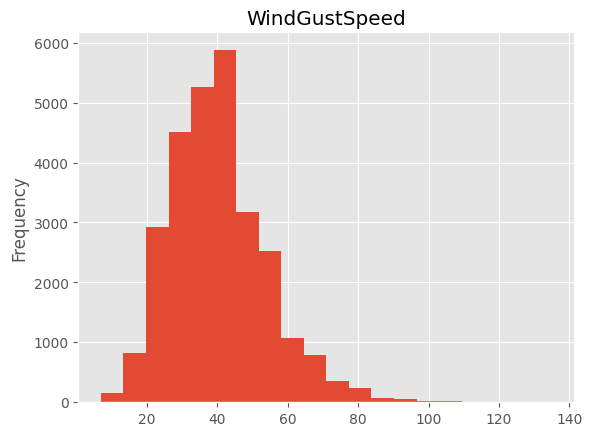

In [176]:
df['WindGustSpeed'].plot(kind='hist', bins=20, title='WindGustSpeed')
plt.gca().spines[['top', 'right',]].set_visible(False)

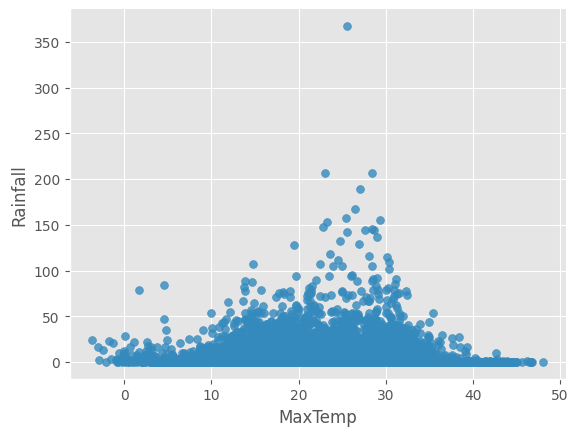

In [177]:
df.plot(kind='scatter', x='MaxTemp', y='Rainfall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

### Encoding

In [178]:
df_encoded = df.copy()
label_encoder = LabelEncoder()
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

In [179]:
df = df_encoded.fillna(df.median()) # substitute NaN values with median of non-NaN values
df.head()

<ipython-input-179-65894a494f45>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df_encoded.fillna(df.median()) # substitute NaN values with median of non-NaN values


,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
100721,22,15.0,18.9,4.2,6,54.0,6,7,24.0,31.0,73.0,64.0,1005.2,1003.7,17.3,17.6,1.0,1.0
30234,37,13.1,26.8,0.0,16,39.0,13,14,22.0,15.0,61.0,22.0,1013.0,1009.0,16.9,25.9,0.0,0.0
68427,18,19.0,29.0,0.0,3,59.0,3,3,39.0,22.0,50.0,38.0,1006.5,1003.4,24.2,27.2,0.0,0.0
28624,34,18.1,32.2,0.0,4,30.0,16,4,0.0,17.0,99.0,51.0,1019.2,1014.6,20.9,31.6,0.0,0.0
31173,37,13.9,19.6,14.0,11,50.0,12,8,17.0,22.0,90.0,64.0,1017.6,1018.4,15.5,19.1,1.0,0.0


### Scaling

Separating target column
 from the feature variables:

In [180]:
features = df.drop("RainTomorrow",axis=1)
target = df["RainTomorrow"]

features.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday
100721,22,15.0,18.9,4.2,6,54.0,6,7,24.0,31.0,73.0,64.0,1005.2,1003.7,17.3,17.6,1.0
30234,37,13.1,26.8,0.0,16,39.0,13,14,22.0,15.0,61.0,22.0,1013.0,1009.0,16.9,25.9,0.0
68427,18,19.0,29.0,0.0,3,59.0,3,3,39.0,22.0,50.0,38.0,1006.5,1003.4,24.2,27.2,0.0
28624,34,18.1,32.2,0.0,4,30.0,16,4,0.0,17.0,99.0,51.0,1019.2,1014.6,20.9,31.6,0.0
31173,37,13.9,19.6,14.0,11,50.0,12,8,17.0,22.0,90.0,64.0,1017.6,1018.4,15.5,19.1,1.0


Using StandardScaler from our skLearn, we'll scale the data:

In [181]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

features.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday
100721,22,15.0,18.9,4.2,6,54.0,6,7,24.0,31.0,73.0,64.0,1005.2,1003.7,17.3,17.6,1.0
30234,37,13.1,26.8,0.0,16,39.0,13,14,22.0,15.0,61.0,22.0,1013.0,1009.0,16.9,25.9,0.0
68427,18,19.0,29.0,0.0,3,59.0,3,3,39.0,22.0,50.0,38.0,1006.5,1003.4,24.2,27.2,0.0
28624,34,18.1,32.2,0.0,4,30.0,16,4,0.0,17.0,99.0,51.0,1019.2,1014.6,20.9,31.6,0.0
31173,37,13.9,19.6,14.0,11,50.0,12,8,17.0,22.0,90.0,64.0,1017.6,1018.4,15.5,19.1,1.0


Let's see how our target data distributes before starting:

0.0    23364
1.0     6636
Name: RainTomorrow, dtype: int64


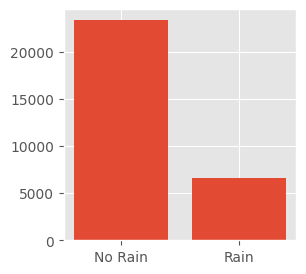

In [182]:
sty.use('ggplot')
plt.figure(figsize=(3,3))
plt.hist(target,bins=2,rwidth=0.8)
plt.xticks([0.25,0.75],['No Rain','Rain'])

print(target.value_counts())

### Training

Let's split the data into training and validation sets using the
scikit-learn function 'train_test_split':

In [183]:
train_x, val_x, train_y, val_y = train_test_split(features, target, test_size=0.2, random_state = 45)

# kNN

### Finding Optimal Neighbor number

To find the optimal number of neighbors, we can use hyperparameter tuning using scikit-learn's GridSearchCV.

In [184]:
knn = KNeighborsClassifier()

k_values = list(range(1, 17, 2))
param_grid = {'n_neighbors': k_values}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]},
             scoring='accuracy')

Let's plot the relation between the accuracy of our validation and the number of neighbors chosen:

Best N: 15
Score for best N: 0.8384166666666666


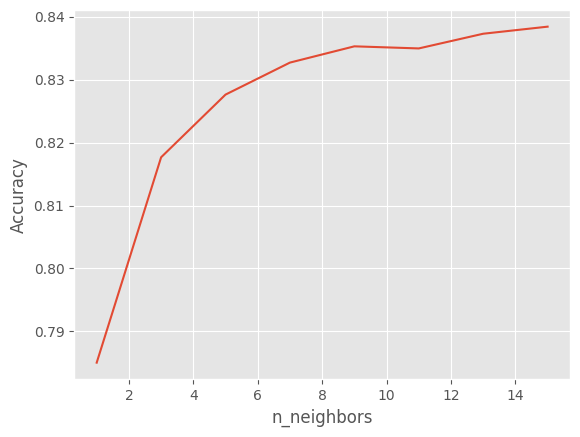

In [185]:
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_n_score = grid_search.best_score_

print("Best N:", best_n_neighbors)
print("Score for best N:", best_n_score)

plt.plot(k_values, grid_search.cv_results_['mean_test_score'])
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

### Training and Predicting

Now we can train our training set with our classifier using the best number of neighbors we've found above.

In [186]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(train_x, train_y)

KNeighborsClassifier(n_neighbors=15)

Let's use our trained model to make predictions on the validation set. We can calculate the precision and accuracy scores:

In [187]:
pred_y_knn = knn.predict(val_x)
precision_knn = precision_score(val_y, pred_y_knn, average='macro')
print('Precision:', precision_knn)

accuracy_knn = knn.score(val_x,val_y)
print('Accuracy:', accuracy_knn)

Precision: 0.790011287995159
Accuracy: 0.8408333333333333


Calculating the precision and accuracy scores:

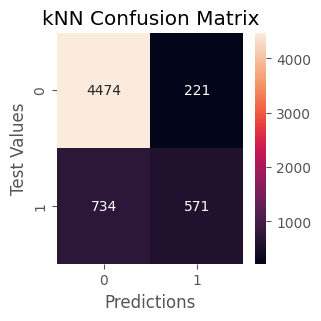

In [188]:
confMatKnn = confusion_matrix(val_y, pred_y_knn)

f, ax = plt.subplots(figsize = (3,3))
sns.heatmap(confMatKnn,annot=True,linecolor="red",fmt=".0f",ax=ax)
plt.title("kNN Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Test Values")
plt.show()

Applying dimensionality reduction using PCA (Principal Component Analysis) so we can visualize our predictions and their scores:

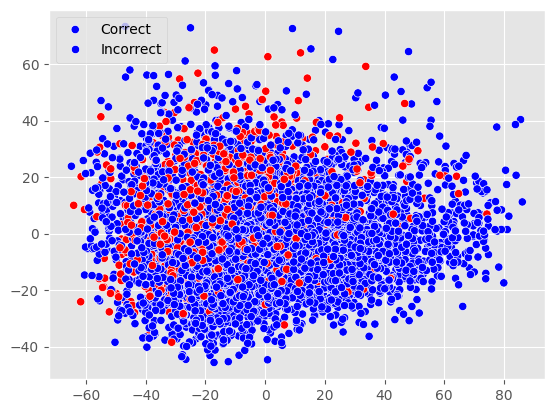

In [189]:
pca = PCA(n_components=2)
val_x_pca = pca.fit_transform(val_x)

result_arr = np.empty(pred_y_knn.shape, dtype=int)

for i in range(pred_y_knn.shape[0]):
    if pred_y_knn[i] == val_y.array[i]:
        result_arr[i] = 0
    else:
        result_arr[i] = 1

sns.scatterplot(x=val_x_pca[:,0], y=val_x_pca[:,1], hue=result_arr, palette={0:'blue', 1:'red'})
plt.legend(labels=['Correct', 'Incorrect'], loc='upper left')
plt.show()

### Learning curve

Let's plot a learning curve so we can compare validatiton and train scores and detect possible overfitting. We'll reuse this function for the other methods to see how differently they select certain parameters and how that impacts the curve.

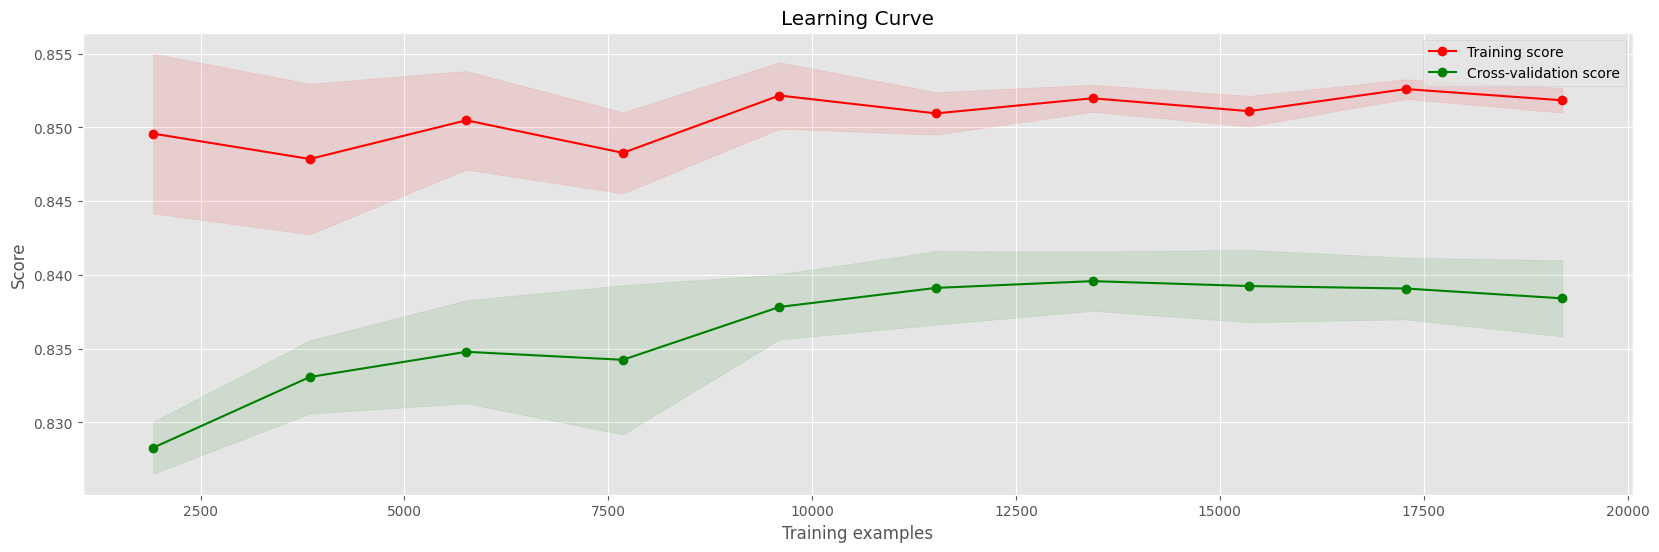

In [219]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(20, 20))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(knn, train_x, train_y)

# Decision Trees

### Training and Predicting

Let's train a Decision Tree classifier on the training data (train_x, train_y).

In [190]:
dtClassifier = tree.DecisionTreeClassifier()
dtClassifier.fit(train_x,train_y)

DecisionTreeClassifier()

Now we can make predictions on the validation set and see how accurate and precise they are:

In [193]:
pred_y_dt = dtClassifier.predict(val_x)

Applying dimensionality reduction using PCA (Principal Component Analysis) so we can visualize our predictions and their scores:

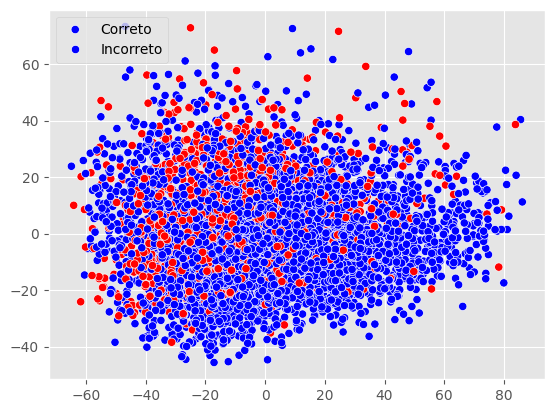

In [194]:
pca = PCA(n_components=2)
val_x_pca = pca.fit_transform(val_x)

result_arr = np.empty(pred_y_dt.shape, dtype=int)

for i in range(pred_y_dt.shape[0]):
    if pred_y_dt[i] == val_y.array[i]:
        result_arr[i] = 0
    else:
        result_arr[i] = 1

sns.scatterplot(x=val_x_pca[:,0], y=val_x_pca[:,1], hue=result_arr, palette={0:'blue', 1:'red'})
plt.legend(labels=['Correct', 'Incorrect'], loc='upper left')
plt.show()

Comparing the above plot with the kNN one, we can see how kNN's performance with the prediction was better than the Decision Tree's.

We can confirm this calculating the precision and accuracy scores:

In [195]:
precision_dt = precision_score(val_y, pred_y_dt, average='macro')
print('Precision:', precision_dt)

accuracy_dt = dtClassifier.score(val_x,val_y)
print("Accuracy:" , accuracy_dt)

Precision: 0.680396290604353
Accuracy: 0.7801666666666667


In [222]:
number_of_nodes = dtClassifier.tree_.node_count
max_depth = dtClassifier.tree_.max_depth

print(f'Total number of nodes: {number_of_nodes}')
print(f'Maximum depth: {max_depth}')

Número total de nós: 5905
Profundidade máxima: 28


Visualizing confusion matrix for our Decision Tree Classifier:

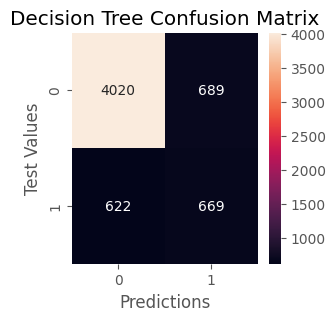

In [138]:
confMatDT = confusion_matrix(val_y,pred_y_dt)

f, ax = plt.subplots(figsize = (3,3))
sns.heatmap(confMatDT,annot=True,linecolor="red",fmt=".0f",ax=ax)
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Test Values")
plt.show()

### Learning curve

Plotting a learning curve to compare validatiton and train scores and detect possible overfitting:

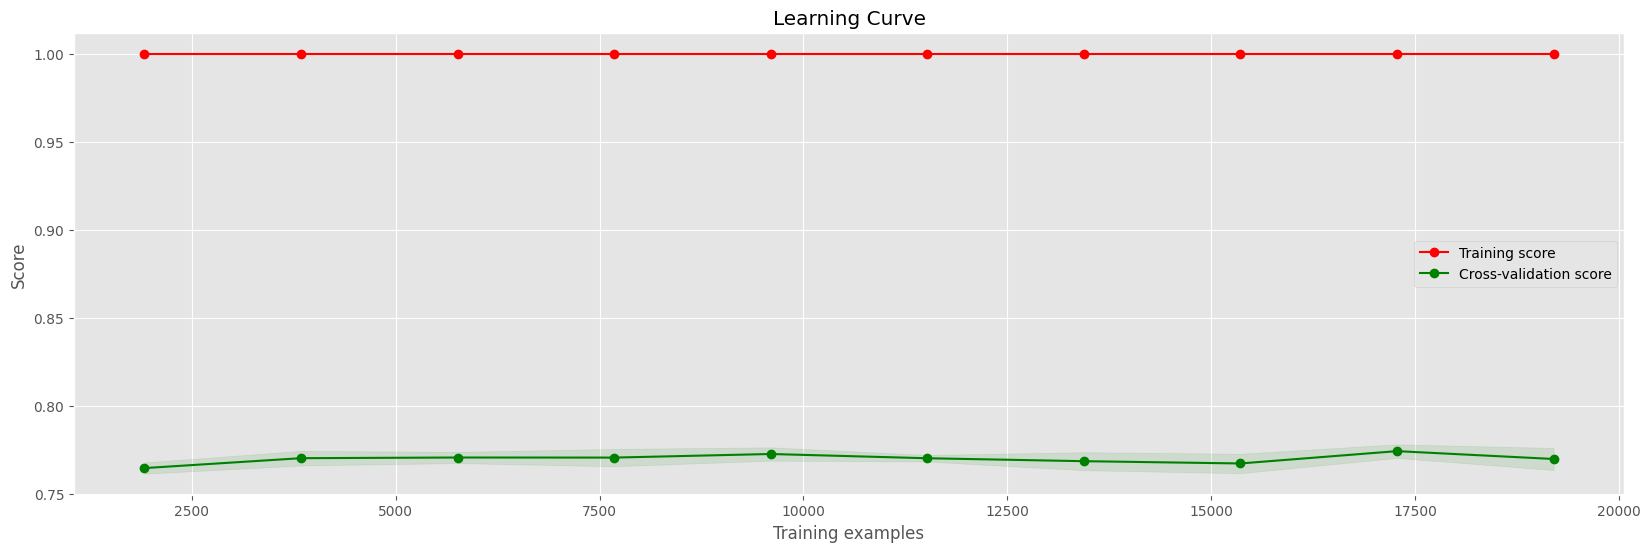

In [220]:
plot_learning_curve(dtClassifier, train_x, train_y)

# Random Forest

### Training

First let's find the optimal depth for our forest, making a comparison between 5 standard possible values:

In [209]:
max_depth_values = [5, 10, 15, 20, 25]
mean_scores = []
for max_depth in max_depth_values:
    rf_classifier = RandomForestClassifier(max_depth=max_depth, random_state=42)
    scores = cross_val_score(rf_classifier, features, target, cv=5)
    mean_score = np.mean(scores)
    mean_scores.append(mean_score)
best_max_depth_index = np.argmax(mean_scores)
best_max_depth = max_depth_values[best_max_depth_index]

print("Best max_depth value:", best_max_depth)
differences = [mean_score - mean_scores[best_max_depth_index] for mean_score in mean_scores]

print("Differences from the best mean score:")
for depth, difference in zip(max_depth_values, differences):
    print(f"max_depth={depth}: difference={difference:.4f}")

Best max_depth value: 20
Differences from the best mean score:
max_depth=5: difference=-0.0103
max_depth=10: difference=-0.0015
max_depth=15: difference=-0.0001
max_depth=20: difference=0.0000
max_depth=25: difference=-0.0017


Finding best estimator number through cross evaluation of the RandomForestClassifier:

In [198]:
scores = []
for n in range(100, 451, 10):
    rf = RandomForestClassifier(n_estimators=n, max_depth=best_max_depth, min_samples_split=12, random_state=45)
    score = np.mean(cross_val_score(rf, features, target, cv=5))
    scores.append({"n":n,'score':score})
    print(f"n_estimators={n}, score={score:.4f}")

n_estimators=100, score=0.8345
n_estimators=110, score=0.8340
n_estimators=120, score=0.8336
n_estimators=130, score=0.8337
n_estimators=140, score=0.8337
n_estimators=150, score=0.8341
n_estimators=160, score=0.8343
n_estimators=170, score=0.8346
n_estimators=180, score=0.8342
n_estimators=190, score=0.8343
n_estimators=200, score=0.8341
n_estimators=210, score=0.8341
n_estimators=220, score=0.8344
n_estimators=230, score=0.8342
n_estimators=240, score=0.8343
n_estimators=250, score=0.8346
n_estimators=260, score=0.8344
n_estimators=270, score=0.8345
n_estimators=280, score=0.8346
n_estimators=290, score=0.8347
n_estimators=300, score=0.8348
n_estimators=310, score=0.8347
n_estimators=320, score=0.8347
n_estimators=330, score=0.8348
n_estimators=340, score=0.8350
n_estimators=350, score=0.8350
n_estimators=360, score=0.8349
n_estimators=370, score=0.8349
n_estimators=380, score=0.8352
n_estimators=390, score=0.8351
n_estimators=400, score=0.8352
n_estimators=410, score=0.8352
n_estima

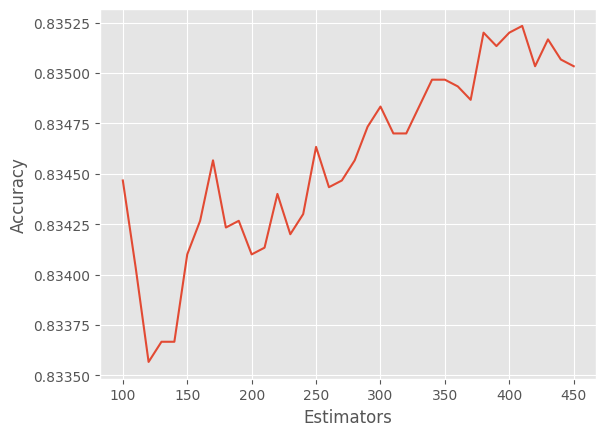

Best n: 410


In [199]:
best_n_estimators = max(scores, key=lambda x:x['score'])['n']
plt.plot(range(100, 451, 10), [item['score'] for item in scores])
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.show()

best_n_estimators = max(scores, key=lambda x:x['score'])['n']
print(f'Best n:', best_n_estimators)

In [202]:
random_forest = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=12, random_state=45)
random_forest.fit(train_x, train_y)

RandomForestClassifier(max_depth=5, min_samples_split=12, n_estimators=15,
                       random_state=45)

### Prediction

Now we can make predictions on the validation set and see how accurate and precise they are:

In [203]:
pred_y_rf = random_forest.predict(val_x)

Applying dimensionality reduction using PCA (Principal Component Analysis) so we can visualize our predictions and their scores:

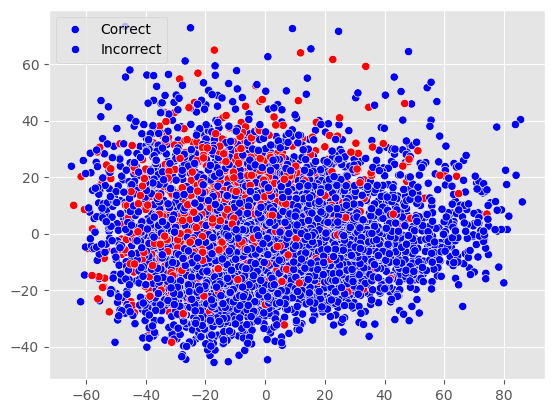

In [205]:
pca = PCA(n_components=2)
val_x_pca = pca.fit_transform(val_x)

result_arr = np.empty(pred_y_rf.shape, dtype=int)

for i in range(pred_y_rf.shape[0]):
    if pred_y_rf[i] == val_y.array[i]:
        result_arr[i] = 0
    else:
        result_arr[i] = 1

sns.scatterplot(x=val_x_pca[:,0], y=val_x_pca[:,1], hue=result_arr, palette={0:'blue', 1:'red'})
plt.legend(labels=['Correct', 'Incorrect'], loc='upper left')
plt.show()

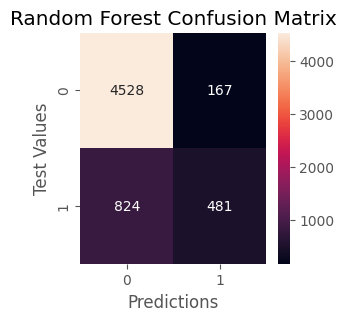

In [206]:
confMatRF = confusion_matrix(val_y,pred_y_rf)

f, ax = plt.subplots(figsize = (3,3))
sns.heatmap(confMatRF,annot=True,linecolor="red",fmt=".0f",ax=ax)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Test Values")
plt.show()

In [162]:
precision_rf = precision_score(val_y, pred_y_rf, average='macro')
print('Precision:', precision_rf)

accuracy_rf = random_forest.score(val_x, val_y)
print("Accuracy:" , accuracy_rf)

Precision: 0.8055633945130751
Accuracy: 0.8375


### Feature importance analysis

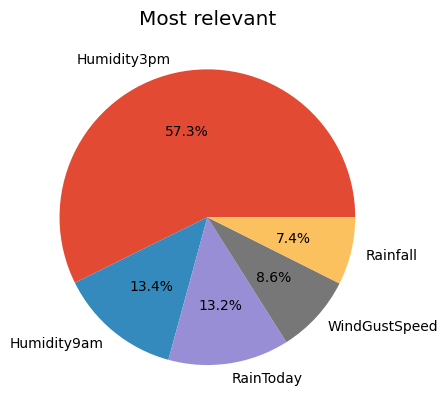

In [207]:
feature_importances = pd.Series(random_forest.feature_importances_, index=features.columns)

feature_importances.nlargest(5).plot(kind='pie', autopct='%1.1f%%')
plt.title('Most relevant')
plt.show()

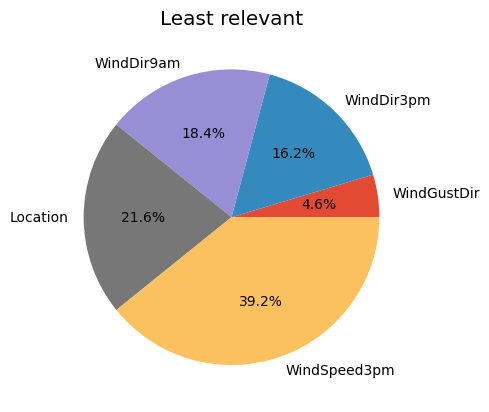

In [208]:
feature_importances.nsmallest(5).plot(kind='pie', autopct='%1.1f%%')
plt.title('Least relevant')
plt.show()

### Learning curve

Plotting a learning curve to compare validatiton and train scores and detect possible overfitting:

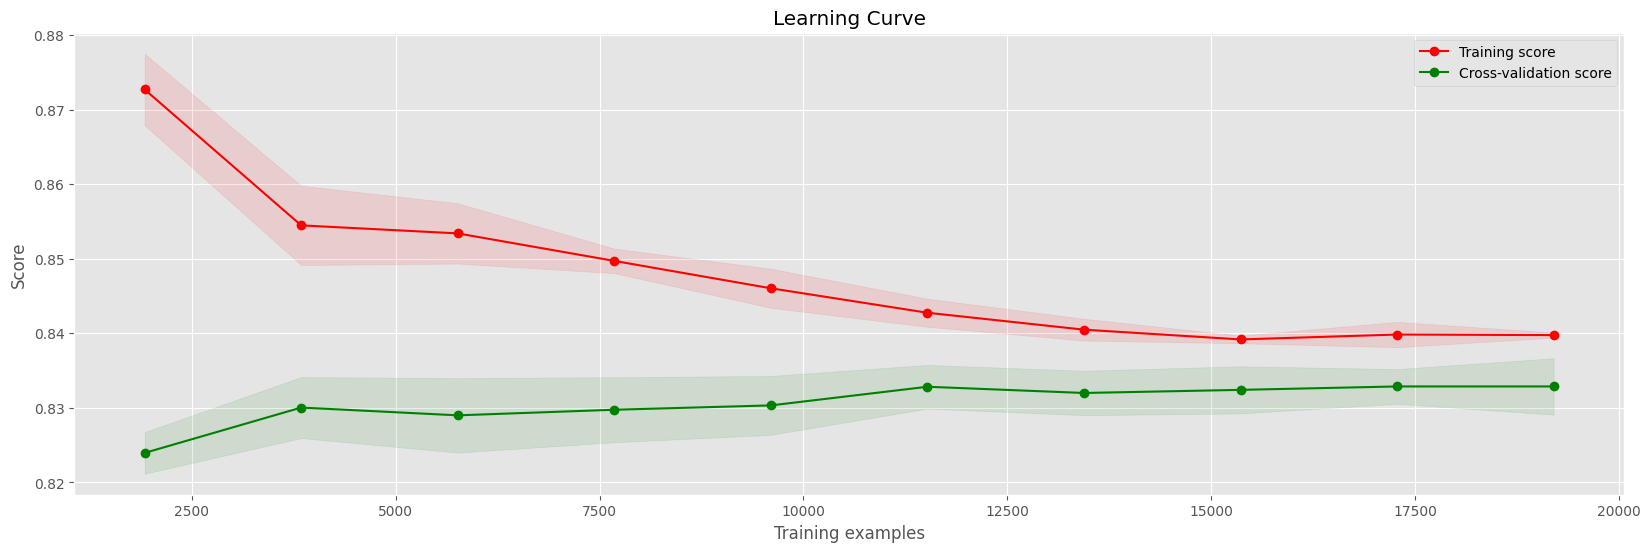

In [221]:
plot_learning_curve(random_forest, train_x, train_y)